<a href="https://colab.research.google.com/github/arslanalan/LSTM/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EPIAS tarafından paylaşılan Gün Öncesi Piyasa (GÖP) verileri üzerinde kısa vadeli tahminler yapılmaya çalışılacaktır. https://seffaflik.epias.com.tr/transparency/ adresinden, istenilen tarih aralığına göre PTF verileri .csv formatında indirilebilmektedir. Öncelikli olarak Şencan tarafından yapılan çalışmadaki veriler üzerinde işlem yapılması planlanmıştır. Dolayısıyla söz konusu çalışmada belirtilen tarih aralığındaki veriler Google Drive klasörüne .csv formatında kaydedilmiştir. Bu veri üzerinde yapılan çalışmalar detaylı olarak açıklanacaktır.

# Gerekli Kütüphanelerin Yüklenmesi
Verinin çalışma ortamına yüklenmesi, ön işlem, makine öğrenmesi algoritmasının uygulanması vb. aşamalarda kullanılacak kütüphaneler yüklenmiştir.

In [0]:
import math

from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pandas import Series
from sklearn import metrics
import tensorflow as tf


# GoogleDrive klasöründen Colaboratory ortamına csv veri dosyası okumak için gerekli kütüphaneler
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# GoogleDrive'a erişmek için kimlik doğrulama
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Detaylı hata logu görülebilmesini sağlıyor. Gerek duyulmazsa çıkarılabilir.
tf.logging.set_verbosity(tf.logging.ERROR)

# Decimal sayılarda iki ondalık gösterilmesi ve ekran satır sayısı ayarı.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15


Using TensorFlow backend.


     |████████████████████████████████| 993kB 4.7MB/s 


Eğitim verisini yüklüyoruz  

In [0]:
link = "https://drive.google.com/open?id=1oxM5OsX21PDmS0P-0nwqL2VGGuHE5KBA"
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')  
winter_train = pd.read_csv('train.csv', decimal=',', thousands='.')
winter_train.head()

,Tarih,Saat,PTF (TL/MWh),PTF (USD/MWh),PTF (EUR/MWh)
0,01/01/2015,00:00,70.23,30.29,24.90
1,01/01/2015,01:00,20.02,8.63,7.10
2,01/01/2015,02:00,0.00,0.00,0.00
3,01/01/2015,03:00,0.00,0.00,0.00
4,01/01/2015,04:00,0.00,0.00,0.00


Test verisini yüklüyoruz. 
















In [0]:
link = "https://drive.google.com/open?id=1y6HmORPWpetXF7847nW9emonzjmEV-yk"
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test.csv')  
winter_test = pd.read_csv('test.csv', decimal=',', thousands='.')
winter_test.head()

,Tarih,Saat,PTF (TL/MWh),PTF (USD/MWh),PTF (EUR/MWh)
0,23/01/2017,00:00,174.94,45.82,43.00
1,23/01/2017,01:00,148.00,38.77,36.38
2,23/01/2017,02:00,89.36,23.41,21.96
3,23/01/2017,03:00,80.74,21.15,19.85
4,23/01/2017,04:00,84.77,22.21,20.84


# Veri Ön İşlem
İndirilen veri kümesinde Tarih ve Saat ayrı sütunlarda ve string formatında bulunmaktadır. Bu iki sütun birleştirilecek ve Date öğesine dönüştürülecektir. Ayrıca veriden USD, EUR ile artık kullanım yeri kalmayacak olan Tarih ve Saat sütunları kaldırılacaktır.

In [0]:
winter_train["Time"] = winter_train[["Tarih", "Saat"]].apply(lambda x: ' '.join(x), axis=1)
winter_train["Time"] = pd.to_datetime(winter_train["Time"], format='%d/%m/%Y %H:%M')
winter_train = winter_train.set_index('Time')
winter_train.drop(["Tarih", "Saat", "PTF (USD/MWh)", "PTF (EUR/MWh)"], axis=1, inplace=True)
winter_train.head()

,PTF (TL/MWh)
Time,
2015-01-01 00:00:00,70.23
2015-01-01 01:00:00,20.02
2015-01-01 02:00:00,0.00
2015-01-01 03:00:00,0.00
2015-01-01 04:00:00,0.00


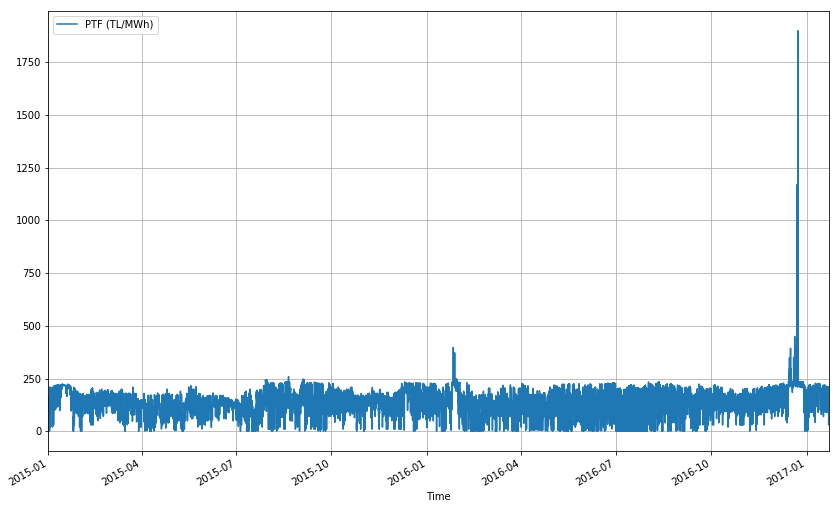

In [0]:
winter_train.plot(grid=True, figsize = (14,9))

In [0]:
winter_test["Time"] = winter_test[["Tarih", "Saat"]].apply(lambda x: ' '.join(x), axis=1)
winter_test["Time"] = pd.to_datetime(winter_test["Time"], format='%d/%m/%Y %H:%M')
winter_test = winter_test.set_index('Time')
winter_test.drop(["Tarih", "Saat", "PTF (USD/MWh)", "PTF (EUR/MWh)"], axis=1, inplace=True)
winter_test.head()

,PTF (TL/MWh)
Time,
2017-01-23 00:00:00,174.94
2017-01-23 01:00:00,148.00
2017-01-23 02:00:00,89.36
2017-01-23 03:00:00,80.74
2017-01-23 04:00:00,84.77


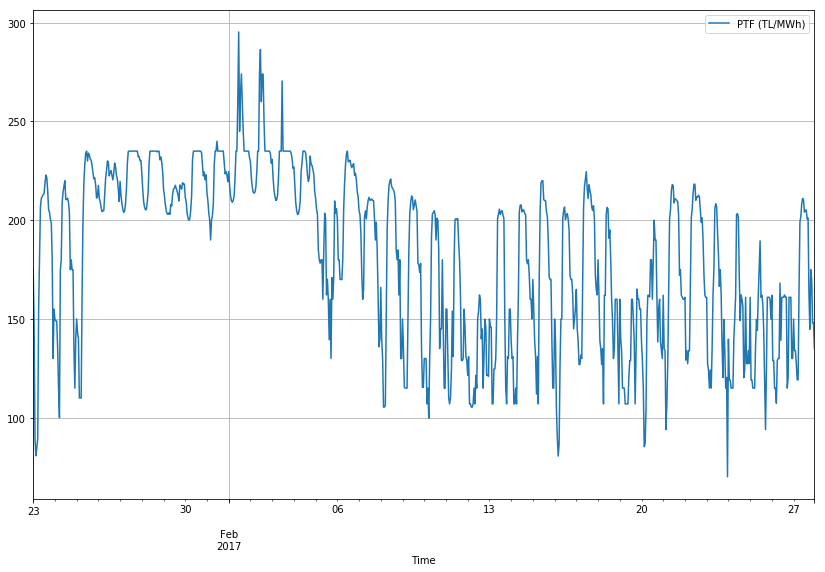

In [0]:
winter_test.plot(grid=True, figsize = (14,9))

In [0]:
## Eğitim verisinden sadece 'PTF (TL/MWh)' sütununu alıyoruz.
winter_training_set = winter_train.iloc[:, 0:1].values
winter_training_set

array([[ 70.23],
       [ 20.02],
       [  0.  ],
       ...,
       [159.99],
       [149.99],
       [168.15]])

In [0]:
# Veri 0-1 aralığına normalize edilecektir.
from sklearn.preprocessing import MinMaxScaler
# Eğitim verisini normalize ediyoruz.
sc = MinMaxScaler(feature_range = (0, 1))
winter_training_set_scaled = sc.fit_transform(winter_training_set)
winter_training_set_scaled

array([[0.03696335],
       [0.0105369 ],
       [0.        ],
       ...,
       [0.08420571],
       [0.07894252],
       [0.08850047]])

In [0]:
# Eğitim verisinden eğitim için kullanılacak veri yapısı oluşturuluyor.
X_train = []
y_train = []
for i in range(24, len(winter_training_set_scaled)):
    X_train.append(winter_training_set_scaled[i-24:i, 0])
    y_train.append(winter_training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
# Eğitim verisi istenilen forma sokuluyor.
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [0]:
#keras'tan Sequential modeli import ediliyor
from keras.models import Sequential
## YSA modeli tanımlanıyor.
model = Sequential()

In [0]:
#model'e LSTM (Long Term Short Term Memory) katmanı eklenecek
from keras.layers import LSTM
# Dropout yapay sinir ağını overfitting'den korumak için kullanılacaktır.
from keras.layers import Dropout
## İlk LSTM katmanı ekleniyor.
#Dropout yapay sinir ağını overfitting'den korumak için kullanılmıştır[].
#X_train.shape[1] özellik sayısını ifade etmektedir. Kaç tane özellik varsa input_shape o kadar olmalıdır.
model.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

In [0]:
## İkinci LSTM katmanı ekleniyor.
model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.2))

In [0]:
## Üçüncü LSTM katmanı ekleniyor.
model.add(LSTM(units = 64, return_sequences = True))
model.add(Dropout(0.2))

In [0]:
## Dördüncü LSTM katmanı ekleniyor.
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

In [0]:
#Dense layer, model'de çıkış katmanı olarak kullanılacak
from keras.layers import Dense
## Çıkış katmanı ekleniyor. Çıkışta tek bir sayı elde edileceğinden tek nörondan oluşan bir "Dense Layer" tanımlanmıştır.
model.add(Dense(units = 1))

In [0]:
#Regresyon problemi olduğundan MSE metriği hesaplanacaktır.
from sklearn.metrics import mean_squared_error
## YSA derleniyor (compiling)
#Optimizasyon yöntemi ve loss fonksiyonu bu aşamada belirtiliyor.
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [0]:
## Katmanlar oluşturuldu, optimizasyon yöntemi ve loss fonksiyonu belirtildi.
#Artık YSA eğitim verisi ile eğitiliyor
model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
18048/18048 [==============================] - 43s 2ms/step - loss: 8.0225e-04
Epoch 2/50
18048/18048 [==============================] - 40s 2ms/step - loss: 5.6882e-04
Epoch 3/50
18048/18048 [==============================] - 40s 2ms/step - loss: 4.2934e-04
Epoch 4/50
18048/18048 [==============================] - 40s 2ms/step - loss: 3.6642e-04
Epoch 5/50
18048/18048 [==============================] - 40s 2ms/step - loss: 3.1161e-04
Epoch 6/50
18048/18048 [==============================] - 40s 2ms/step - loss: 3.0571e-04
Epoch 7/50
18048/18048 [==============================] - 40s 2ms/step - loss: 3.0375e-04
Epoch 8/50
18048/18048 [==============================] - 40s 2ms/step - loss: 2.8399e-04
Epoch 9/50
18048/18048 [==============================] - 40s 2ms/step - loss: 2.9916e-04
Epoch 10/50
18048/18048 [==============================] - 40s 2ms/step - loss: 2.6841e-04
Epoch 11/50
18048/18048 [==============================] - 40s 2ms/step - loss: 2.6902e-04
Epoch 12

In [0]:
# Tahmin yapılacak test verisi hazırlanıyor

winter_test_set = winter_test.iloc[:, 0:1].values
winter_test_set

In [0]:
#Oluşturulan model ile test verisi üzerinde tahmin yapılıyor.
winter_total = pd.concat((winter_train['PTF (TL/MWh)'], winter_test['PTF (TL/MWh)']), axis = 0)
inputs = winter_total[len(winter_total) - len(winter_test) - 24:].values
inputs

In [0]:
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
inputs

In [0]:
X_test = []
for i in range(24, len(inputs)):
    X_test.append(inputs[i-24:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test

In [0]:
predicted_PTF = model.predict(X_test)
predicted_PTF = sc.inverse_transform(predicted_PTF)

In [0]:
#Sonuçlar yazdırılıyor
plt.plot(winter_test, color = 'red', label = 'Gerçek PTF')
plt.plot(predicted_PTF, color = 'blue', label = 'Tahmin edilen PTF')
plt.title('PTF Tahmin')
plt.xlabel('Saat')
plt.ylabel('PTF')
plt.legend()
plt.show()